# 1. Preprocessing

## 1.1 What is Preprocessing?
In this notebook, we survey some snippets of code that help 'preprocess' your corpus of medieval texts. The preprocessing of text files is an elementary but fundamental step in ensuring reliability of stylometric analyses. One could argue that especially with texts from the Middle Ages preprocessing is key and perhaps more crucial then when you are digitally analyzing texts written in periods after the invention of the printing press. Stylometry’s application to medieval texts comes with specific desiderata when compared to, for instance, authorship detection of current-day online, electronically available blog posts. As a result of manuscript culture, medieval texts can be tremendously varied. These variations can tell us much about varying editing principles, or various recensions or writing conventions across scriptoria, but more often than not they are redundant when what you want to look at is authorship and literary style.

Preprocessing (potentially) entails steps such as these:

* the removal and editing of all irrelevant characters in the text: punctuation, numerals, optical character recognition errors, case-folding, titles or annotations, etc …
* ‘tokenising’ the text to meaningful units, often word tokens

If so desired, preprocessing also takes care of this: 
* normalization / standardization: align variant orthographical and editorial conventions between text versions
* disambiguation, for instance to semantically distinguish homographs.
* stemming (recover basis stem or morphological root of word tokens
* lemmatisation transforms word tokens to a standard dictionary form
* PoS(part-of-speech)-tagging and parsing: identify a token’s part of speech and syntactic function
* automated scansion for prosodic units of analysis


## 1.2 Reading and Handling File Objects 

The first step is reading in your corpus of texts, so that we can start manipulating them. The steps below will be easier to follow and execute correctly if you have ensured that your file names are formatted as such: ```author-name_text-title.txt```. 

In [18]:
import glob
import os

current_directory = os.getcwd() # gets current directory
folder_path = current_directory + '/corpus/train' # gets directory path to corpus folder containing .txt files

for filename in glob.glob(folder_path + '/*'):
    print(filename)

/Users/jedgusse/Documents/UGent - Lokaal/Conferences/GRAZ - Summer School “Computational Language Technologies for Medievalists”/Graz/corpus/train/Petrus-Cellensis_Epistolae.txt
/Users/jedgusse/Documents/UGent - Lokaal/Conferences/GRAZ - Summer School “Computational Language Technologies for Medievalists”/Graz/corpus/train/Joannes-Saresberiensis_Epistolae.txt
/Users/jedgusse/Documents/UGent - Lokaal/Conferences/GRAZ - Summer School “Computational Language Technologies for Medievalists”/Graz/corpus/train/Hildegardis-Bingensis_Liber-diuinorum-operum.txt


Below is a rather large chunk of code in which a number of consecutive steps are introduced and combined. 
First, we declare empty list containers (```authors```, ```titles```, ```texts```), where we will store our metadata and data.
We introduce our first stylometric parameter, the sample length (variable ```sample_len```)
We then go over all files in the folder, and extract the data and metadata from the files, using the ```glob``` module.

In the text itself, we use the ```re``` (RegEx Module in Python, which stands for regular expressions) which removes digits and punctuation from the text (if so desired). We also apply case folding (convert upper to lowercase).

Once the data has been 'cleared' of all text items that are insignificant for stylistic analysis, we proceed by slicing up the data into discrete segments, or chunks of text.

In [20]:
import re
import glob
from string import punctuation

# Declare empty lists to fill up with our metadata and data
authors, titles, texts = [], [], []

# We declare some parameters — the 'settings' of our stylometric experiments
sample_len = 1400 # word length of text segment

# Function to clean and split text
def clean_and_split_text(text, sample_len):
    words = re.sub(r'[\d%s]' % re.escape(punctuation), '', text.lower()).split()
    return [words[i:i + sample_len] for i in range(0, len(words), sample_len)]

# Open all file objects in folder and gather data
for filename in glob.glob(folder_path + '/*'):
    # Extract author and title from filename
    author, title = filename.split('/')[-1].split('.')[0].split('_')[:2]

    with open(filename, encoding='utf-8-sig') as file:
        text = file.read().strip()
        bulk = clean_and_split_text(text, sample_len)

        for index, sample in enumerate(bulk):
            if len(sample) == sample_len:
                authors.append(author)
                titles.append(f"{title}_{index + 1}")
                texts.append(" ".join(sample))

## 1.3 Sampling (Text Segmentation)

Despite many permutations, sampling methods generally fall within one of these four categories: (a) discrete, (b) rolling, (c) random and (d) generative.

* **Discrete** is as above. A longer text is sliced in discrete pieces according to a predefined fixed sample size, where the next sample picks up the trail where the previous one ended.
* **Rolling**: makes use of a sliding window, it 'shingles' your text segments. Rolling segmentation samples the text in non-identical, partially overlapping windows instead of discrete chunks of text. It is generally considered to be a more sensitive way of linearly scanning the stylistic profile of a text, and registers how it changes from first to last word. 
* **Random**: sentences from a certain author’s entire oeuvre are randomly selected until a predefined sample length limit is reached (e.g. keep on randomly selecting until 1,000 words have been found) in order to come to an almost inexhaustible number of new, real-world representations of the author’s lexical distribution through new combinations.
* **Generative**: closely related to random sampling, but takes the idea of inexhaustible representability of a stylistic profile one more step further. Text generation attempts to not only imitate the distribution by making use of extant text samples, but even expands a corpus by generating new text. Needless to say this is an interesting yet underexplored area of research for medieval texts. Some work has been done in this regard for Latin-writing late antique and medieval authors (Manjavacas et al. 2017).

### 1.3.1 Rolling Sampling 

The block of code below allows you to apply a relatively easy form of sampling, that of **rolling sampling**. The `step_size`-variable specifies the number of words between the starting indices of consecutive samples. For example, if `step_size=100`, each sample starts 100 words after the previous sample. It determines the amount of overlap between consecutive samples. 

In [24]:
import re
import numpy as np
from string import punctuation

# Declare empty lists to fill up with our metadata and data
authors = []
titles = []
texts = []

sample_len = 1400 # word length of text segment
step_size = 200 # step size

for filename in glob.glob(folder_path + '/*'):
    author, title = filename.split("/")[-1].split(".")[0].split("_")[:2]
    with open(filename, 'r') as file:
        text = file.read().lower()
        text = re.sub('[%s]' % re.escape(punctuation), '', text)
        text = re.sub('\d+', '', text)
        words = text.split()
        steps = np.arange(0, len(words), step_size)
        for each_begin in steps:
            sample_range = range(each_begin, each_begin + sample_len)
            sample = [words[index] for index in sample_range if index < len(words)]
            if len(sample) == sample_len:
                key = '{}-{}-{}'.format(title, str(each_begin), str(each_begin + sample_len))
                authors.append(author)
                titles.append(key)
                texts.append(" ".join(sample))

print(authors[:5])
print(titles[:5])

['Petrus-Cellensis', 'Petrus-Cellensis', 'Petrus-Cellensis', 'Petrus-Cellensis', 'Petrus-Cellensis']
['Epistolae-0-1400', 'Epistolae-200-1600', 'Epistolae-400-1800', 'Epistolae-600-2000', 'Epistolae-800-2200']


### 1.3.2 Random sampling

The code block below gives you a starting point to experiment with **random sampling**. The variable `word_limit` is virtually the same as the desired `sample_len` above: it indicates how many words you want to include in your sample. `n_samples` yields the desired number of random samples per author.

In [26]:
import re
import glob
from string import punctuation
import random

# Upper word limit (or sample length)
word_limit = 1400
n_samples = 10 # number of desired randomly generated segments per author

# Function that counts the number of words in a list of sentences
def count_words(sentences):
    return sum(len(sentence.split()) for sentence in sentences)
    
# Function that samples sentences until the word limit is reached
def sample_sentences(sentences, word_limit):
    sampled_sentences = []
    total_words = 0
    remaining_sentences = sentences.copy()
    
    while total_words < word_limit and remaining_sentences:
        sentence = random.choice(remaining_sentences)
        sentence_word_count = len(sentence.split())
        if total_words + sentence_word_count <= word_limit:
            sampled_sentences.append(sentence)
            total_words += sentence_word_count
        remaining_sentences.remove(sentence)
    
    return sampled_sentences

data = {}
# Open all file objects in folder and gather data
for filename in glob.glob(folder_path + '/*'):
    # Extract author and title from filename
    author, title = filename.split('/')[-1].split('.')[0].split('_')[:2]
    data[author] = []
    with open(filename, encoding='utf-8-sig') as file:
        text = file.read().strip()
        sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)
        for sentence in sentences:
            data[author].append(sentence)

# Store randomly sampled data for each author
authors, titles, texts = [], [], []
sampled_data = {}
for author in data.keys():
    sampled_data[author] = []
for author, sentences in data.items():
    for i in range(0, n_samples):
        random_sample = sample_sentences(sentences, word_limit)
        random_sample = ' '.join(random_sample)
        title = 'sample_' + str(i+1) # indexes random samples
        authors.append(author)
        titles.append(title)
        texts.append(random_sample)

## 1.4 Advanced NLP Annotation for Ancient and Medieval Languages

Depending on what your source language is, you may want to **standardize** (normalize), **stem**, **lemmatize**, **tag**, **parse** or **scan** your texts. Here CLTK (The Classical Language Toolkit) can provide ways in which one could accomplish this.

### [The Classical Language Toolkit](https://docs.cltk.org/en/latest/index.html)

The Classical Language Toolkit (CLTK) offers natural language processing (NLP) support for the languages of Ancient, Classical, and Medieval Eurasia. Greek, Latin, Akkadian, and the Germanic languages are currently most complete.
To install CLTK, open your Terminal, and type:

`$ pip install cltk`

CLTK depends on libraries `Stanza NLP` (Stanford NLP Group's official Python NLP library), `fastText` (open-source, free, lightweight library that allows users to learn text representations and text classifiers), or external dictionaries of the language you are analyzing. The CLTK will offer to download these for you.

Available languages in CLTK are:

* Akkadian
* Arabic
* Aramaic
* Classical Chinese
* Coptic
* Gothic
* Greek
* Hindi
* Latin
* Middle High German
* English
* French
* Old Church Slavonic
* Old Norse
* Pali
* Panjabi
* Sanskrit

When you call nlp on a text, `cltk` (similar to `spaCy`) first tokenizes the text to produce a doc object. The doc is then processed in several different steps – this is also referred to as the processing pipeline. The pipeline used by the trained pipelines typically include a tagger, a lemmatizer, a parser and an entity recognizer. Each pipeline component returns the processed doc, which is then passed on to the next component.

In [28]:
from cltk import NLP
import pickle # library to help save / serialize data obtained after costly performances

cltk_nlp = NLP(language="lat") # find the abbreviation to summon up the language of choice
# ‎𐤀 CLTK version '1.0.11'.
# Pipeline for language 'Latin' (ISO: 'lat'): `LatinNormalizeProcess`, `LatinStanzaProcess`, `LatinEmbeddingsProcess`, `StopsProcess`, `LatinNERProcess`, `LatinLexiconProcess`.

# Will ask you to download Stanza NLP library on which CLTK depends.
# If it asks that, it is safe to download these in order to optimize performance.

# Note that cltk_nlp.analyze() (i.e. tokenization, PoS-tagging, lemmatization, morphology, NER, syntax, etc.) can take some time
cltk_docs = []
for segment in texts[:1]:  # [:1] is a slicing operation where we only look at first segment of corpus
    cltk_doc = cltk_nlp.analyze(text=segment) # returns variety of linguistic features and annotations
    cltk_docs.append(cltk_doc)

# Considering that tokenizing, lemmatizing, tagging, etc. your texts of choice can be a rather costly operation
# to perform computationally (it takes quite a bit of time), it can be convenient to store your data in a serialized 
# data format (converted into a saved, reconstructable format) which can later be deserialized and called.
with open(current_directory + '/output/cltk_docs.pkl', 'wb') as f:
    pickle.dump(cltk_docs, f)

‎𐤀 CLTK version '1.3.0'. When using the CLTK in research, please cite: https://aclanthology.org/2021.acl-demo.3/

Pipeline for language 'Latin' (ISO: 'lat'): `LatinNormalizeProcess`, `LatinSpacyProcess`, `LatinEmbeddingsProcess`, `StopsProcess`, `LatinLexiconProcess`.

⸖ ``LatinSpacyProcess`` using LatinCy model by Patrick Burns from https://huggingface.co/latincy . Please cite: https://arxiv.org/abs/2305.04365
⸖ ``LatinEmbeddingsProcess`` using word2vec model by University of Oslo from http://vectors.nlpl.eu/ . Please cite: https://aclanthology.org/W17-0237/
⸖ ``LatinLexiconProcess`` using Lewis's *An Elementary Latin Dictionary* (1890).

⸎ To suppress these messages, instantiate ``NLP()`` with ``suppress_banner=True``.


In [32]:
from cltk import NLP
import pickle

# Load the data from the pickle file
with open(current_directory + '/output/cltk_docs.pkl', 'rb') as f:
    cltk_docs = pickle.load(f)

# Print the loaded data
for cltk_doc in cltk_docs: # extract annotations from the NLP doc object
    tokens = cltk_doc.tokens
    lemmata = cltk_doc.lemmata
    pos_tags = cltk_doc.pos

print(tokens[:5])
print(lemmata[:5])
print(pos_tags[:5])

['Utinam', 'radios', 'suos', 'libere', ',']
['Utinam', 'radius', 'suus', 'libere', ',']
['ADV', 'NOUN', 'ADJ', 'ADV', 'PUNCT']


## 1.5 Semantic Features: Word Embeddings

A distinct and somewhat more advanced field is that of **semantic word embeddings**, which focus on features that encapsulate 'semantic' information. Here, we cannot but address a few principles that —at this point— may be not entirely clear yet, but will, at a later stage in notebook 4, become much clearer. 

The least technical way to explain embeddings, its fundamental premise, in other words, is that the meaning of a word can be inferred from the contexts in which it occurs: **you can understand a word by the company it keeps**. 

### 1.5.1 Base Principles of Word Embeddings

An ‘embedding’ is simply an alternative naming for ‘vector representation of a word’, i.e. a word represented in ‘some vector space’. In other words, word embeddings work as **vector representations** (which we wil learn more about in the next notebook). 

A word embedding typically starts out by representing a word as a so-called **one-hot vector**:

`sparse = [0, 0, 1, 0, ... , n]`  
Where *n* signifies number of encountered words in the corpus. The column where `1` occurs, is what identifies the word within the vocabulary.

In a vocabulary containing 3 words, one-hot vectors would look like this:

| the      | quick |  brown |
| ----------- | ----------- | -----------|
| 1 | 0 | 0 | 
| 0 | 1 | 0  |
| 0 | 0 | 1 |

One-hot vectors are so-called **sparse** representations, i.e. containing `0`'s except a single `1`. The length of the vector equals the total vocabulary size. Word embedding models at first turn these sparse representations into dense ones. In so doing, they are virtually 2-layer **neural networks**.  
At first, the word gains a random dense representation of a fixed, lower dimensionality (e.g. vector length of 3, such as here):

`dense = [0.2, 0.1, 0.4]`  
Where *n* is 3.

Consequently, through training, these dense representations are 'transformed' in order to better represent the word by its context. The idea is that **words with similar meanings will have similar vector representations**. To accomplish this, the model minimizes a loss function (minimizes its prediction error), where vectors of those words frequently appearing in similar contexts end up having similar vectors.

The model trains itself to look at a target word's 'context window' (either larger of smaller values that indicate the *k* neighbours to take into account) and in iteratively adjusting the embedding matrix, keeps track of significant word relationships.

#### Example Sentence:
"The quick brown fox jumps over the lazy dog"

#### Context Window Size: 2

| Target Word | Context Words             |
|-------------|----------------------------|
| The         | quick, brown               |
| quick       | The, brown, fox            |
| brown       | The, quick, fox, jumps     |
| fox         | quick, brown, jumps, over  |
| jumps       | brown, fox, over, the      |
| over        | fox, jumps, the, lazy      |
| the         | jumps, over, lazy, dog     |
| lazy        | over, the, dog             |
| dog         | the, lazy                  |



### 1.5.2 Training and Pre-Trained Embeddings

Word embeddings can be trained on our own given corpus of texts by using packages like `Gensim`, a free open source Python library. This can be quite useful and informative to get a hang of how this algorithm works. However, in order to save time, make your findings more replicable, and guarantee higher quality, we can also use **pre-trained embeddings**.

Word representation methods such as `word2vec`and `FastText` (developed by Facebook) can be used in Python to load already **pre-trained embeddings**, or to declare a new model to train on your own data. These models are trained on Wikipedia and Common Crawl data. You will need to have the FastText library installed to work with FastText models, especially if you need to load models that are in FastText's binary format. Gensim can interface with FastText models, but having the FastText library installed ensures compatibility and provides additional functionalities.

For Latin, it is possible to **download and compress** the files by typing the below. 
**Be careful, this will take some time to download.**

In [ ]:
# Be careful, running this block launches a download
import fasttext.util
# ft = fasttext.load_model('cc.la.300.bin')
ft = fasttext.load_model('/Users/jedgusse/cc.la.300.bin')
# If you get: "ValueError: cc.la.300.bin cannot be opened for loading!" - try to specify the full path name to the vectors file

Once you have downloaded the file containing the pre-trained vectors, you can can load an embeddings-model using the Python lines given below. Note that it may be the case that you will have to specify the full path name when loading the model with the line `ft = fasttext.load_model('')`.

In [ ]:
import fasttext.util
fasttext.util.download_model('la', if_exists='ignore')  # 'la' for Latin

When you run the block of code below, you will print the full vector representation (in 300 dimensions) of the word 'abbas'. Feel free to try out a few other Latin words.

When training a word-embeddings model, the **dimensionality** of the vector space can in fact be chosen. Commonly used dimensions in research are 100, 200, and 300 (such as here). These provide a good starting point. Best practice has it that you train models with different vector sizes (e.g., 50, 100, 200, 300). Consequently, you evaluate the performance of these models on your specific task (e.g., word similarity, text classification, etc. — see notebook 4). The corpus size and language complexity can also be significant factors in deciding on dimensionality. 	The ‘attributes’ (i.e. features, each dimension of the matrix that constitutes a ‘king’ to being a ‘king’) are not explicit or determinable. They are weighted / calculated by the algorithm through relations with other words


In [192]:
import numpy as np
np.set_printoptions(suppress=True, precision=2) # suppresses scientific notation 

print("Continuous vector representation for abbatissa:")
print(ft.get_word_vector('abbatissa'))
print("Dimension of word vector for 'abbatissa':")
ft.get_word_vector('abbatissa').shape

Continuous vector representation for abbatissa:
[ 0.06 -0.04 -0.    0.05 -0.11 -0.01 -0.01 -0.05 -0.02  0.02  0.02  0.01
  0.02 -0.02  0.    0.03  0.04  0.01 -0.    0.    0.01 -0.03 -0.01 -0.04
 -0.01 -0.02 -0.09 -0.01 -0.01 -0.06  0.   -0.03  0.04 -0.01  0.04  0.02
 -0.02  0.01  0.01  0.02 -0.02 -0.11  0.03  0.    0.    0.08 -0.03 -0.02
 -0.04 -0.01  0.01 -0.03  0.05 -0.02  0.03  0.02 -0.04  0.03 -0.03  0.02
  0.02 -0.01 -0.01  0.06  0.01 -0.04  0.02 -0.02 -0.01 -0.03  0.03 -0.02
  0.01 -0.03  0.02 -0.02  0.05 -0.08 -0.03  0.04 -0.01 -0.05 -0.    0.08
  0.04  0.02 -0.05  0.02  0.    0.03 -0.01  0.02 -0.04  0.03  0.02 -0.03
  0.   -0.05  0.07 -0.01 -0.04 -0.01  0.01  0.01  0.06  0.03  0.01 -0.04
 -0.02  0.02 -0.01  0.03  0.02  0.04  0.04 -0.    0.05 -0.02 -0.01 -0.01
 -0.03 -0.03 -0.05 -0.02  0.04  0.05 -0.01 -0.04  0.03 -0.03  0.03 -0.03
 -0.07 -0.01 -0.01  0.03  0.04  0.06 -0.05 -0.03  0.04  0.01  0.    0.01
 -0.03  0.04 -0.04 -0.02 -0.06 -0.02  0.02 -0.02 -0.01 -0.    0.03  0.02
 -0

(300,)

Consequently, by launching `ft.get_nearest_neighbors` you can look at the *k* words that are most similar to the input word. These similarities are not always easily explained in one sense. Sometimes they are clearly semantic, but you will also notice by looking at the list of nearest neighbors that embeddings pick up on some orthographical or morphological variations of the word, or even to words that look like or sound like the word in question.

In [194]:
similar_words = ft.get_nearest_neighbors('abbatissa', k=10) # k indicates number of neighbors
print(similar_words)

[(0.8354274034500122, 'abbatissas'), (0.8308930993080139, 'abbatissae'), (0.7990221381187439, 'abbatissam'), (0.7571409344673157, 'Abbatissa'), (0.7449652552604675, 'abatissa'), (0.7117032408714294, 'abbatiace'), (0.693352460861206, 'abbati'), (0.6908366084098816, 'Abatissa'), (0.664496660232544, 'abbatiis'), (0.6616677641868591, 'abbatio')]


In [157]:
import numpy as np

words_of_interest = ['herba', 'planta', 'folia', 'flores', 'radix', 'fructus', 'semen', 'herbarium', 'species', 'genus', 'familia', 'habitat', 'cultivar', 'virtus', 'usus', 'dosage', 'infusio', 'decoctio', 'extractum', 'tinctura', 'deus', 'trinitas', 'incarnatio', 'salvatio', 'redemptio', 'fides', 'gratia', 'peccatum', 'caritas', 'ecclesia', 'sacramentum', 'veritas', 'revelatio', 'sanctus', 'mysterium', 'divinitas', 'humanitas', 'oratio', 'aeternitas', 'regnum dei']
embeddings = []
for word in words_of_interest: 
    embedding = ft.get_word_vector(word)
    embeddings.append(embedding)
embeddings = np.array(embeddings)

0.3968897 0.31081885 -0.34170175
0.32206786 0.19227314 -0.09210095
0.8468242 0.3253077 0.40375945
0.40829 0.20305423 0.27790022
0.17325255 -0.023963481 -0.3998872
0.1816983 0.1601803 0.109512165
0.06884486 0.17496581 -0.14391029
0.093721844 0.0052899886 -0.037726197
0.07027895 -0.016717032 -0.101127766
-0.11103207 0.07120903 0.018635742
0.030826915 -0.080683686 -0.12513061
-0.114062555 -0.062016178 -0.1900469
0.047268562 -0.047883015 -0.07857579
-0.15351956 0.04211161 0.06144528
-0.054071322 0.012873022 0.17858072
-0.014624153 -0.116159275 -0.07191816
0.056757268 0.010006836 -0.013059282
0.023610128 -0.0708372 -0.029698212
0.05447578 -0.07981991 -0.12830195
0.08742356 0.007189196 -0.076551385
-0.7238395 1.0080884 0.005538418
-0.14221194 -0.041990146 0.025681637
-0.08427032 -0.09845434 -0.016334845
-0.13310839 -0.08712656 0.005526795
-0.02485375 -0.14205614 0.024294093
-0.26040074 -0.13785923 0.72907996
-0.014207685 -0.09348761 0.006226776
-0.101119064 -0.074807584 0.00039694563
-0.1550

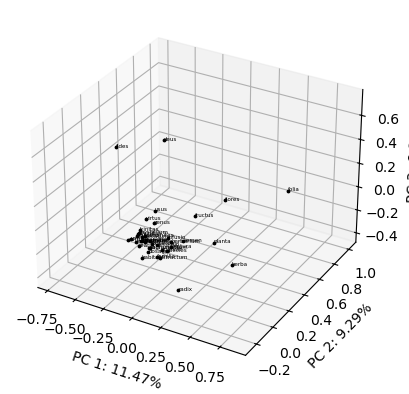

In [153]:
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer, StandardScaler, FunctionTransformer, MinMaxScaler
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import random
import os

pca = PCA(n_components=3)

X_bar = pca.fit_transform(embeddings) # dimensionality reduction

# Extract the explained variance
var_exp = pca.explained_variance_ratio_
var_pc1 = np.round(var_exp[0]*100, decimals=2)
var_pc2 = np.round(var_exp[1]*100, decimals=2)
var_pc3 = np.round(var_exp[2]*100, decimals=2)
explained_variance = np.round(sum(pca.explained_variance_ratio_)*100, decimals=2)

# Make scatterplot

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x1, x2, x3 = X_bar[:,0], X_bar[:,1], X_bar[:,2]

for p1, p2, p3, word in zip(x1, x2, x3, words_of_interest):
    print(p1, p2, p3)
    ax.scatter(p1, p2, p3, color='k',s=3)
    ax.text(p1, p2, p3, s=word, fontdict={'size': 4})

ax.set_xlabel('PC 1: {}%'.format(var_pc1))
ax.set_ylabel('PC 2: {}%'.format(var_pc2))
ax.set_zlabel('PC 3: {}%'.format(var_pc3))

plt.show()

current_directory = os.getcwd() # gets current directory
# Get the current time
current_time = datetime.now()
# Format the current time as a string
formatted_time = current_time.strftime("date %d-%m at %Hh%Mm")
fig.savefig(current_directory + '/output/embeddings-3D-{}.png'.format(current_time), dpi=300, transparent=True, format='png')